In [3]:
import time
import numpy as np
import qiskit
from qiskit.opflow import X,Z,I
from qiskit.opflow.state_fns import StateFn, CircuitStateFn
from qiskit.providers.aer import StatevectorSimulator, AerSimulator
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import COBYLA, SLSQP, SPSA
import matplotlib.pyplot as plt
from scipy import sparse
import scipy.sparse.linalg.eigen.arpack as arp
from modules.utils import *

from tenpy.networks.mps import MPS
from tenpy.models.hubbard import BoseHubbardChain
from tenpy.algorithms import dmrg
from tenpy.linalg import np_conserved

%matplotlib inline

# TENPY

In [24]:
def DMRG_EBH(L, V, t_list, chi_max=30, bc_MPS='infinite'):

    model_params = dict(n_max=1, filling=0.5, bc_MPS=bc_MPS, t=t_list,
                        L=L, V=V, mu=0, conserve='N', verbose=0)
    M = BoseHubbardChain(model_params)
        
    vector=[]
    for i in range(M.lat.N_sites):
        if i%2:
            vector.append(1)
        else:
            vector.append(0)

    psi = MPS.from_product_state(M.lat.mps_sites(), vector, bc=M.lat.bc_MPS)    
        
    dmrg_params = {                                                                                             
        'mixer': True,                                                                                          
        'trunc_params': {                                                                                       
        'chi_max': chi_max,                                                                                                                                                                    
        },                                                                                                      
        'max_E_err': 1.e-16,                                                                                    
        'verbose': 0
    }
    
    info = dmrg.run(psi, M, dmrg_params)
    
    return info['E'], psi

## INFINITE

In [ ]:
chi = 50
V_list = np.linspace(2,8,10)
deltat_list = np.linspace(-1,1,10)
L = 4
mu = 0
deltat = 0.5
site = 0

psi_array = []

for deltat in deltat_list:
    
    print('deltat', deltat)
    t_list = np.ones(L)
    for i in range(len(t_list)):
        t_list[i] -= deltat*(-1)**i
    
    psi_0 = []
    for V in V_list:

        print('V', V)
        E0, psi0 = DMRG_EBH(L, V, t_list, chi_max=chi)
        psi_0 = np.append(psi_0, psi0)

    psi_array.append(psi_0)
    
    np.save('data/BH_MPS.npy',  psi_array)

In [6]:
psi_array = np.load('data/BH_MPS.npy', allow_pickle=True)
r = 200

ES_array = []
parity_array = []
dd_array = []

V_list = np.linspace(2,8,10)
deltat_list = np.linspace(-1,1,10)

for j,deltat in enumerate(deltat_list):
    
    ES_list = []
    parity_list = []
    dd_list = []

    psi_list = psi_array[j]
    
    for i,V in enumerate(V_list):
        
        psi = psi_list[i]
    
        ES = np.exp(-np.array(psi.entanglement_spectrum()[2]))
        dES = -np.sum(ES[::2])+np.sum(ES[1::2])
        ES_list.append(dES)
        
        dd = psi.expectation_value('dN')[2]
        dd_list.append(dd)
        
        dN_op = psi.sites[0].get_op('dN')
        exp_op = np_conserved.expm(1.j * np.pi * dN_op)
        psi.sites[0].add_op('exp_op', exp_op, hc = False)
        op_array1 = np.repeat('exp_op',r)
        op_array2 = np.repeat('exp_op',r+1)
        parity = (psi.expectation_value_multi_sites(op_array1, i0=0) + psi.expectation_value_multi_sites(op_array2, i0=0))/2
        parity_list.append(parity)
        
    parity_array.append(parity_list)
    dd_array.append(dd_list)
    ES_array.append(ES_list)

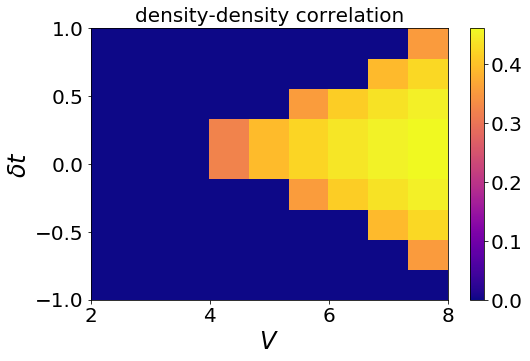

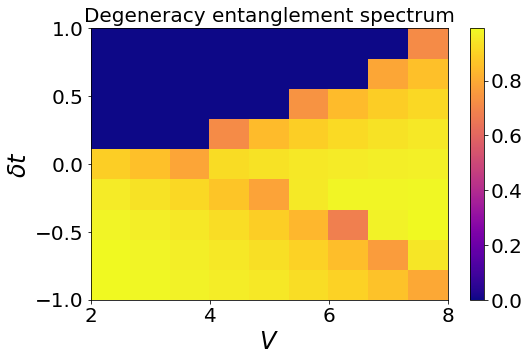

In [7]:
V_list = np.linspace(2,8,10)
deltat_list = np.linspace(-1,1,10)

fig,ax = plt.subplots(figsize=(8,5))
cmap = plt.get_cmap("plasma") #'viridis'
im = ax.pcolormesh(V_list, deltat_list, np.abs(dd_array), cmap=cmap)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
ax.set_title("density-density correlation",fontsize=20)
ax.set_xlabel(r"$V$",fontsize=24)
ax.set_ylabel(r"$\delta t$",fontsize=24)
ax.tick_params(labelsize=20)

fig,ax = plt.subplots(figsize=(8,5))
cmap = plt.get_cmap("plasma") #'viridis'
im = ax.pcolormesh(V_list, deltat_list, np.abs(ES_array), cmap=cmap)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
ax.set_title("Degeneracy entanglement spectrum",fontsize=20)
ax.set_xlabel(r"$V$",fontsize=24)
ax.set_ylabel(r"$\delta t$",fontsize=24)
ax.tick_params(labelsize=20)

# FINITE

In [ ]:
chi = 50
V_list = np.linspace(2,8,10)
deltat_list = np.linspace(-1,1,10)
L = 5
mu = 0
deltat = 0.5
site = 0

psi_array = []

for deltat in deltat_list:
    
    print('deltat', deltat)
    t_list = np.ones(L-1)
    for i in range(len(t_list)):
        t_list[i] -= deltat*(-1)**i
    
    psi_0 = []
    for V in V_list:

        print('V', V)
        E0, psi0 = DMRG_EBH(L, V, t_list, chi_max=chi, bc_MPS='finite')
        psi_0 = np.append(psi_0, psi0)

    psi_array.append(psi_0)
    
    np.save('data/BH_MPS_L%.0f.npy' %L, psi_array)

# L = 20

In [12]:
L = 20
psi_array = np.load('data/BH_MPS_L%.0f.npy' %L, allow_pickle=True)
r = L-1

ES_array = []
parity_array = []
dd_array = []

V_list = np.linspace(2,8,10)
deltat_list = np.linspace(-1,1,10)

for j,deltat in enumerate(deltat_list):
    
    ES_list = []
    parity_list = []
    dd_list = []

    psi_list = psi_array[j]
    
    for i,V in enumerate(V_list):
        
        psi = psi_list[i]
    
        ES = np.exp(-np.array(psi.entanglement_spectrum()[2]))
        dES = -np.sum(ES[::2])+np.sum(ES[1::2])
        ES_list.append(dES)
        
        dd = psi.expectation_value('dN')[int(L/2)]
        dd_list.append(dd)
        
        dN_op = psi.sites[0].get_op('dN')
        exp_op = np_conserved.expm(1.j * np.pi * dN_op)
        psi.sites[0].add_op('exp_op', exp_op, hc = False)
        op_array1 = np.repeat('exp_op',r)
        op_array2 = np.repeat('exp_op',r+1)
        parity = (psi.expectation_value_multi_sites(op_array1, i0=0) + psi.expectation_value_multi_sites(op_array2, i0=0))/2
        parity_list.append(parity)
        
    parity_array.append(parity_list)
    dd_array.append(dd_list)
    ES_array.append(ES_list)

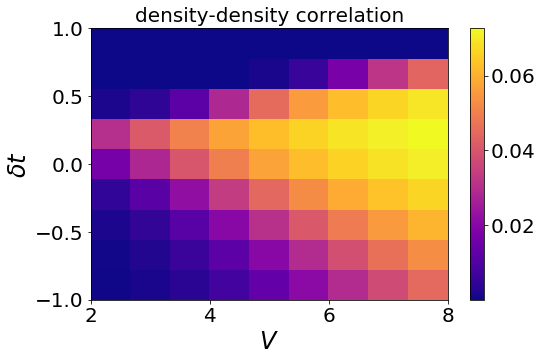

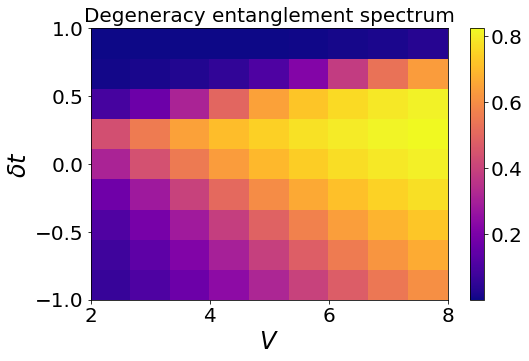

In [13]:
V_list = np.linspace(2,8,10)
deltat_list = np.linspace(-1,1,10)

fig,ax = plt.subplots(figsize=(8,5))
cmap = plt.get_cmap("plasma") #'viridis'
im = ax.pcolormesh(V_list, deltat_list, np.abs(dd_array), cmap=cmap)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
ax.set_title("density-density correlation",fontsize=20)
ax.set_xlabel(r"$V$",fontsize=24)
ax.set_ylabel(r"$\delta t$",fontsize=24)
ax.tick_params(labelsize=20)

fig,ax = plt.subplots(figsize=(8,5))
cmap = plt.get_cmap("plasma") #'viridis'
im = ax.pcolormesh(V_list, deltat_list, np.abs(ES_array), cmap=cmap)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
ax.set_title("Degeneracy entanglement spectrum",fontsize=20)
ax.set_xlabel(r"$V$",fontsize=24)
ax.set_ylabel(r"$\delta t$",fontsize=24)
ax.tick_params(labelsize=20)

In [21]:
L = 20
psi_array = np.load('data/BH_MPS_L%.0f.npy' %L, allow_pickle=True)
wf_array = []
V_array = []
deltat_array = []

V_list = np.linspace(2,8,10)
deltat_list = np.linspace(-1,1,10)

for i, deltat in enumerate(deltat_list):
    for j, V in enumerate(V_list):
        
        psi = psi_array[i][j]
        wf = psi.get_theta(0,L).to_ndarray().reshape(-1)
        wf_array.append(wf)
        V_array.append(V)
        deltat_array.append(deltat)

np.savez(f'data/wf_BH_L%.0f.npz' %(L), deltat_array=deltat_array, V_array=V_array, wf_array = wf_array)

## L = 5

In [26]:
L = 5
psi_array = np.load('data/BH_MPS_L%.0f.npy' %L, allow_pickle=True)
r = L-1

ES_array = []
parity_array = []
dd_array = []

V_list = np.linspace(2,8,10)
deltat_list = np.linspace(-1,1,10)

for j,deltat in enumerate(deltat_list):
    
    ES_list = []
    parity_list = []
    dd_list = []

    psi_list = psi_array[j]
    
    for i,V in enumerate(V_list):
        
        psi = psi_list[i]
    
        ES = np.exp(-np.array(psi.entanglement_spectrum()[2]))
        dES = -np.sum(ES[::2])+np.sum(ES[1::2])
        ES_list.append(dES)
        
        dd = psi.expectation_value('dN')[int(L/2)]
        dd_list.append(dd)
        
        dN_op = psi.sites[0].get_op('dN')
        exp_op = np_conserved.expm(1.j * np.pi * dN_op)
        psi.sites[0].add_op('exp_op', exp_op, hc = False)
        op_array1 = np.repeat('exp_op',r)
        op_array2 = np.repeat('exp_op',r+1)
        parity = (psi.expectation_value_multi_sites(op_array1, i0=0) + psi.expectation_value_multi_sites(op_array2, i0=0))/2
        parity_list.append(parity)
        
    parity_array.append(parity_list)
    dd_array.append(dd_list)
    ES_array.append(ES_list)

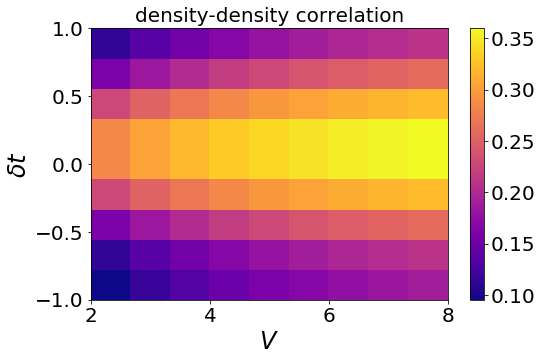

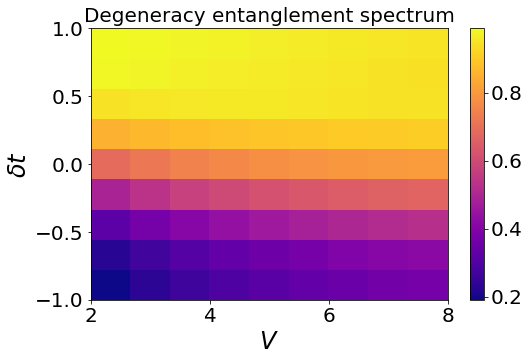

In [27]:
V_list = np.linspace(2,8,10)
deltat_list = np.linspace(-1,1,10)

fig,ax = plt.subplots(figsize=(8,5))
cmap = plt.get_cmap("plasma") #'viridis'
im = ax.pcolormesh(V_list, deltat_list, np.abs(dd_array), cmap=cmap)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
ax.set_title("density-density correlation",fontsize=20)
ax.set_xlabel(r"$V$",fontsize=24)
ax.set_ylabel(r"$\delta t$",fontsize=24)
ax.tick_params(labelsize=20)

fig,ax = plt.subplots(figsize=(8,5))
cmap = plt.get_cmap("plasma") #'viridis'
im = ax.pcolormesh(V_list, deltat_list, np.abs(ES_array), cmap=cmap)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
ax.set_title("Degeneracy entanglement spectrum",fontsize=20)
ax.set_xlabel(r"$V$",fontsize=24)
ax.set_ylabel(r"$\delta t$",fontsize=24)
ax.tick_params(labelsize=20)

In [28]:
L = 5
psi_array = np.load('data/BH_MPS_L%.0f.npy' %L, allow_pickle=True)
wf_array = []
V_array = []
deltat_array = []

V_list = np.linspace(2,8,10)
deltat_list = np.linspace(-1,1,10)

for i, deltat in enumerate(deltat_list):
    for j, V in enumerate(V_list):
        
        psi = psi_array[i][j]
        wf = psi.get_theta(0,L).to_ndarray().reshape(-1)
        wf_array.append(wf)
        V_array.append(V)
        deltat_array.append(deltat)

np.savez(f'data/wf_BH_L%.0f.npz' %(L), deltat_array=deltat_array, V_array=V_array, wf_array = wf_array)

# EXACT DIAGONALIZATION

In [79]:
def DEBHM_groundstate(L, V, deltat):
    """For comparison: obtain ground state energy from exact diagonalization.
    Exponentially expensive in L, only works for small enough `L` <~ 20.
    
    L:number of sites 
    V: density-density interactions
    t1: hopping 1
    t2: hopping 2
    mu: chemical potential
    """
    if L >= 20:
        warnings.warn("Large L: Exact diagonalization might take a long time!")
        
    # get single site operaors
    sp = sparse.csr_matrix(np.array([[0., 1.], [0., 0.]]))
    sm = sparse.csr_matrix(np.array([[0., 0.], [1., 0.]]))
    sx = sparse.csr_matrix(np.array([[0., 1.], [1., 0.]]))
    sz = sparse.csr_matrix(np.array([[1., 0.], [0., -1.]]))
    id = sparse.csr_matrix(np.eye(2))
    
    sz_list = []  # sx_list[i] = kron([id, id, ..., id, sx, id, .... id])
    sp_list = []
    sm_list = []    
    for i_site in range(L):
        z_ops = [id] * L
        p_ops = [id] * L
        m_ops = [id] * L
        z_ops[i_site] = sz
        p_ops[i_site] = sp
        m_ops[i_site] = sm
        Z = z_ops[0]
        P = p_ops[0]
        M = m_ops[0]
        for j in range(1, L):
            Z = sparse.kron(Z, z_ops[j], 'csr')
            P = sparse.kron(P, p_ops[j], 'csr')
            M = sparse.kron(M, m_ops[j], 'csr')
        sz_list.append(Z)
        sp_list.append(P)
        sm_list.append(M)
    H_hop = sparse.csr_matrix((2**L, 2**L))
    H_mu = sparse.csr_matrix((2**L, 2**L))
    H_V = sparse.csr_matrix((2**L, 2**L))
    for i in range(L - 1):
        H_hop = H_hop + ((-1)**L*deltat)*(sp_list[i] * sm_list[(i + 1) % L] + sm_list[i] * sp_list[(i + 1) % L])
    for i in range(L - 1):
        H_V = H_V + V*sz_list[i] * sz_list[(i + 1) % L]
    for i in range(L):
        H_mu = H_mu + mu*sz_list[i]
    H = -H_mu - H_hop + H_V
    E, V = arp.eigsh(H, k=1, which='SA', return_eigenvectors=True, ncv=20)
    
    return V[:,0], E[0], H

def CDW_op(L, evec): 

    sz = sparse.csr_matrix(np.array([[1., 0.], [0., -1.]]))
    id = sparse.csr_matrix(np.eye(2))
    
    sz_list = []  # sx_list[i] = kron([id, id, ..., id, sx, id, .... id])
    for i_site in range(L):
        z_ops = [id] * L
        z_ops[i_site] = sz
        Z = z_ops[0]
        for j in range(1, L):
            Z = sparse.kron(Z, z_ops[j], 'csr')
        sz_list.append(Z)
    dd = sparse.csr_matrix((2**L, 2**L))
    dd = dd + (sz_list[1] * sz_list[int(L/2)])
    
    return np.conjugate(init_state).T@dd@init_state  

def N_op(L, evec): 

    sz = sparse.csr_matrix(np.array([[1., 0.], [0., -1.]]))
    id = sparse.csr_matrix(np.eye(2))
    
    sz_list = []  # sx_list[i] = kron([id, id, ..., id, sx, id, .... id])
    for i_site in range(L):
        z_ops = [id] * L
        z_ops[i_site] = sz
        Z = z_ops[0]
        for j in range(1, L):
            Z = sparse.kron(Z, z_ops[j], 'csr')
        sz_list.append(Z)
    Nexp = sparse.csr_matrix((2**L, 2**L))
    for i in range(L):
        Nexp = Nexp + sz_list[i]
    
    return np.conjugate(init_state).T@Nexp@init_state  

In [ ]:
V_list = np.linspace(2,8,10)
deltat_list = np.linspace(-1,1,10)
L = 6
mu = 1

energies = np.zeros((10,10))
CDW = np.zeros((10,10))
Nexp = np.zeros((10,10))
for i,deltat in enumerate(deltat_list):
    for j,V in enumerate(V_list):
        init_state, E, ham = DEBHM_groundstate(L, V, deltat)
        energies[i][j] = E
        CDW[i][j] = CDW_op(L, np.array(init_state))
        Nexp[i][j] = N_op(L, np.array(init_state))

In [ ]:
plt.imshow(CDW)
plt.colorbar()

In [ ]:
plt.imshow(Nexp)
plt.colorbar()